# AOS_singleAmpMag

#  Difference in star magnitude for overlapping stars on a single Amplifier

### Motivation 

A notebook to test the performance of comcam close loop (estimation of Zernike polynomials from the Wavefront Estimation Calculation pipeline) as the simulated stars are kept close (perhaps overlapping), keeping the magnitude of primary fixed, and varying the magnitude of the secondary. Thus we explore the effect of the magnitude difference between two nearby (overlapping) stars, $\Delta m$

### Performance Metric 

The RMS value between OPD results and the Zernike polynomials given by ts_wep output.

### Test Data 

Created on UW *epyc*, in `epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/`. 

The exact steps:

    cd /epyc/users/suberlak/Commissioning/aos/
    source setup_aos_2020_15.sh 
    cd  ts_phosim/notebooks/analysis_scripts/
    python runSingleAmpStarMag.py


In [6]:
#Note: can display all arguments, and even run from the ipython notebook,.
#but I find that then not all the console output gets printed here 
# - could be run as a subprocess, but then the output gets stored in wrong ISO format...
# 
!python ../analysis_scripts/runSingleAmpStarMag.py -h

usage: runSingleAmpStarMag.py [-h] [--testLabel TESTLABEL]
                              [--magPrimary MAGPRIMARY] [--starSep STARSEP]
                              [--numPro NUMPRO] [--iterNum ITERNUM]
                              [--numFields NUMFIELDS] [--numStars NUMSTARS]
                              [--opd] [--flats] [--defocalImg]
                              [--doDeblending] [--postageImg]
                              [--topDir TOPDIR] [--expDir EXPDIR]
                              [--copyDir COPYDIR]

Run ComCam AOS closed loop for varying star magnitude at fixed separation

optional arguments:
  -h, --help            show this help message and exit
  --testLabel TESTLABEL
                        test label
  --magPrimary MAGPRIMARY
                        magnitude for the primary (fixed)
  --starSep STARSEP     star separation, in percentage of ra span of the
                        amplifier - for the default 5 %, the donuts overlap.
  --numPro NUMPRO       number of p

## Results

In [41]:
import os
from astropy.table import Table
import numpy as np

# IMPORT CUSTOM FUNCTIONS 
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics
import analysisTools as at 

# IMPORT LSST MODULES 
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [42]:
# setup the location of analysis files ... 
baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_after_centroid_update'
resDir = 'singleAmpMagNew'


Note: the following results were processed with `2020_15` version of the LSST Stack. Thus I use `lsst_phosim` kernel (with `2020_15` stack) to read them (otherwise the Butler will complain and refuse to work). The `lsst-aos` shared kernel has `2020_24` stack as of 7/27/2020. 

Illustrate what we are doing (running the AOS loop 10 times, each time simulating two stars per CCD, with 9 ComCam CCDs) by plotting full image of several CCDs : 

In [44]:
# #get the freshest version
# import imp
# imp.reload(at)

In [45]:
mag=16
data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
image = at.readPostISRImage(data_dir, focalType = 'extra', raft = 'R22', detector = 'S00',)


data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done



In [47]:
centroid, centFlag = at.readCentroidInfo(data_dir, focalType='extra', raft='R22',detector='S00')

Reading centroid files from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpMagNew/mag_16/iter0/img/extra
The following files are available:
centroid_lsst_e_9006001_f1_R22_S12_E000.txt
centroid_lsst_e_9006001_f1_R22_S11_E000.txt
centroid_lsst_e_9006001_f1_R22_S21_E000.txt
centroid_lsst_e_9006001_f1_R22_S00_E000.txt
centroid_lsst_e_9006001_f1_R22_S22_E000.txt
centroid_lsst_e_9006001_f1_R22_S01_E000.txt
centroid_lsst_e_9006001_f1_R22_S20_E000.txt
centroid_lsst_e_9006001_f1_R22_S10_E000.txt
centroid_lsst_e_9006001_f1_R22_S02_E000.txt
Using centroid_lsst_e_9006001_f1_R22_S00_E000.txt 


Reading info about postage-stamp images from postagedonutStarsExtraIntra.txt


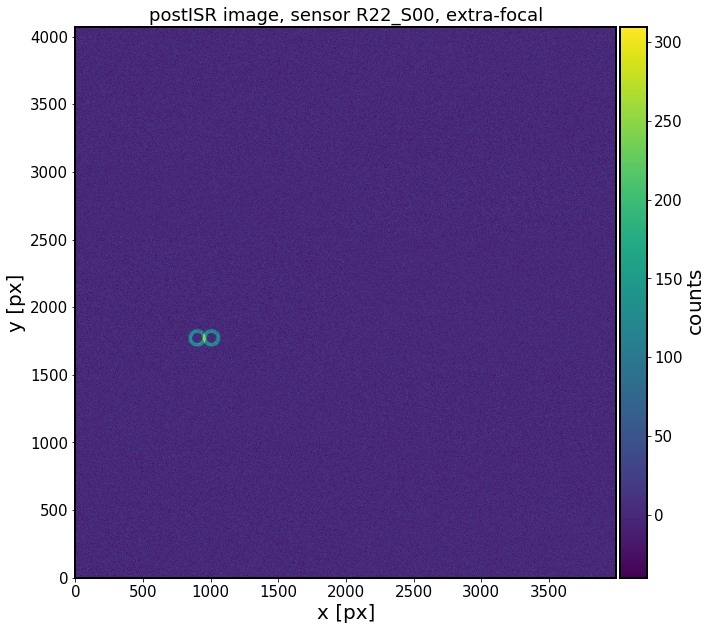

In [50]:
%matplotlib inline
postage, postFlag =  at.readPostageStars(data_dir)
at.plotImage(image,ax=None, log=False, sensor='R22_S00', focalType='extra',
          postage=postage,postFlag=False, centroid=centFlag, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross')

The available magnitudes are : 

In [51]:
os.listdir(os.path.join(baseDir, topDir,resDir))

['mag_16',
 'starCat_16.txt',
 'mag_15',
 'starCat_15.txt',
 'mag_14',
 'starCat_14.txt',
 'mag_13',
 'starCat_13.txt',
 'mag_12',
 'starCat_12.txt',
 'mag_11',
 'starCat_11.txt',
 'mag_10',
 'starCat_10.txt']

Plot rms difference for primary=16 mag, and secondary=[15] mag:

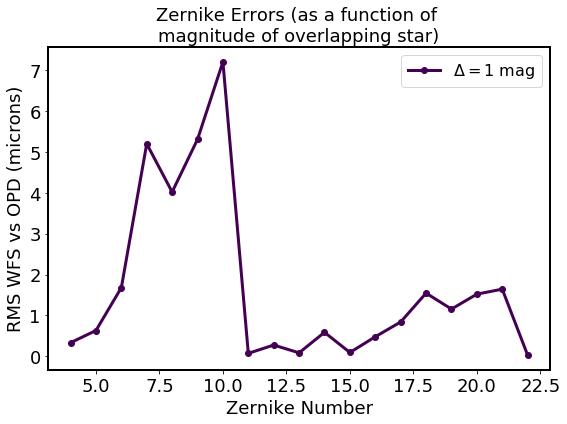

In [54]:
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


magArr = [15]

N = len(magArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

testLabel='mag'

for mag in magArr :
    testName  = '%s.%d' % (testLabel, mag)
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.'+ testName)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.'+ testName)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData
    wfsData = wfsData
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
#     zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
#     ssrFieldVals.append(zerFieldSSR)
#     ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


magPrimary = 16 

fig = plt.figure(figsize=(8,6))

for i in range(len(magArr)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label=r'$\Delta =%d$ mag ' % (magPrimary-magArr[i]),color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of \nmagnitude of overlapping star)', size=18)
    
plt.tight_layout()
# plt.savefig('StarSep_singleAmp_sep5perc_varyMag_rms_wfs_vs_opd_1.png', bbox_inches='tight', 
#            dpi=100)

Plot rms difference for primary=16 mag, and secondary = [14,13,12,11,10] mag :

In [55]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


magArr = [14,13,12,11,10]#15,14,13,12,11,10]

N = len(magArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

testLabel='mag'

for mag in magArr :
    testName  = '%s.%d' % (testLabel, mag)
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.'+ testName)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.'+ testName)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData
    wfsData = wfsData
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


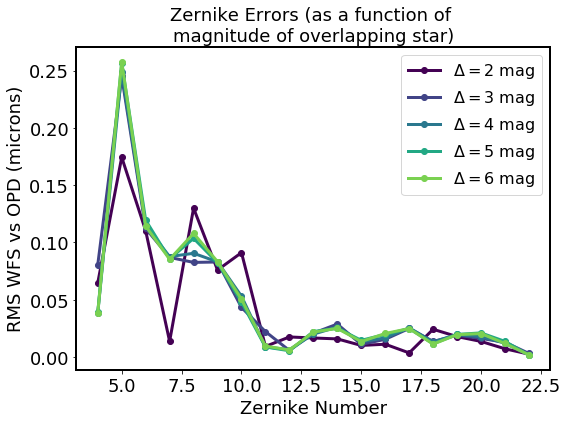

In [56]:
magPrimary = 16 

fig = plt.figure(figsize=(8,6))

for i in range(len(magArr)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label=r'$\Delta =%d$ mag ' % (magPrimary-magArr[i]),color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of \nmagnitude of overlapping star)', size=18)
    
plt.tight_layout()
# plt.savefig('StarSep_singleAmp_sep5perc_varyMag_rms_wfs_vs_opd_1.png', bbox_inches='tight', 
#            dpi=100)

Note: this is similar to results in Manuel+2010 "Curvature wavefront sensing performance evaluation for active correction of the Large Synoptic Survey Telescope (LSST)"
* Fig.9 explains how stars fainter than mag 10 but brighter than 17 (depending on the wavelength) will be used for WFS : "stars this bright will not be used for curvature sensing. This is because they saturate the CWFS detector and are not very plentiful. The number of stars that exist at each larger magnitude grows geometrically. Most of the stars used for curvature sensing will be in the magnitude range of 12 < m < 17, " 
* in Chap 3.9 she explains the problem of overlapping stars  "Two stars will overlap if they are not at least ~16 arcseconds (80 pixel diameter × 0.2 arcseconds/pixel) apart." - his Fig.12 actually considers what I discovered , that as long as the deltaM is above ~3 the CWFS error is below 200 nm rms : 

<img src='Manuel_2010_Fig12.png'></img>

## Walk through postage stamp creation in `ts_wep`

Plot rms wavefront error alongside a postISR image cutout around the extra-focal simulated stars for one sensor (R22_S00) for each pair of magnitude differences

In [57]:
# Read each figure as a postage stamp, store data to an array 
images = {}
magArr = [16,15,14,13,12,11,10]
for mag in magArr:
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    images[mag] = at.readPostISRImage(data_dir, focalType = 'extra', obsId=None, raft = 'R22',
                     detector = 'S00', detNum = None, verbose=True)
    

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Done



In [58]:
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


magArr = [16,15,14,13,12,11,10]

N = len(magArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

testLabel='mag'

for mag in magArr :
    testName  = '%s.%d' % (testLabel, mag)
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.'+ testName)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.'+ testName)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData
    wfsData = wfsData
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))

    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,
../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,
../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,
../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,
../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,
../analysis_tools/analysisTools.py:300: RuntimeWarning: invalid value encountered in log10
  img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,
../analysis_tool

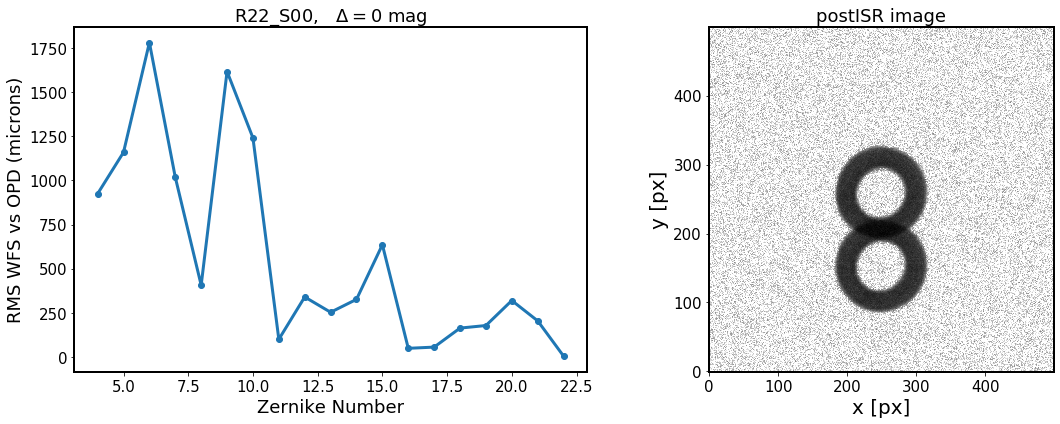

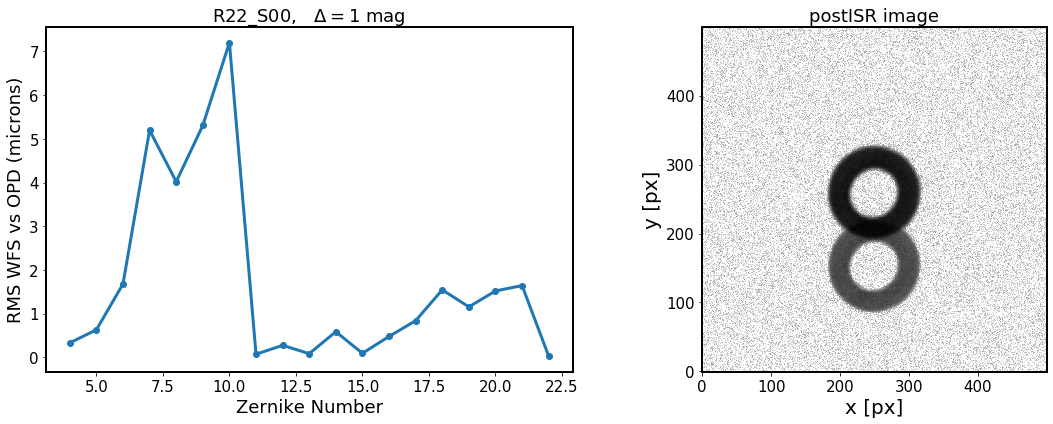

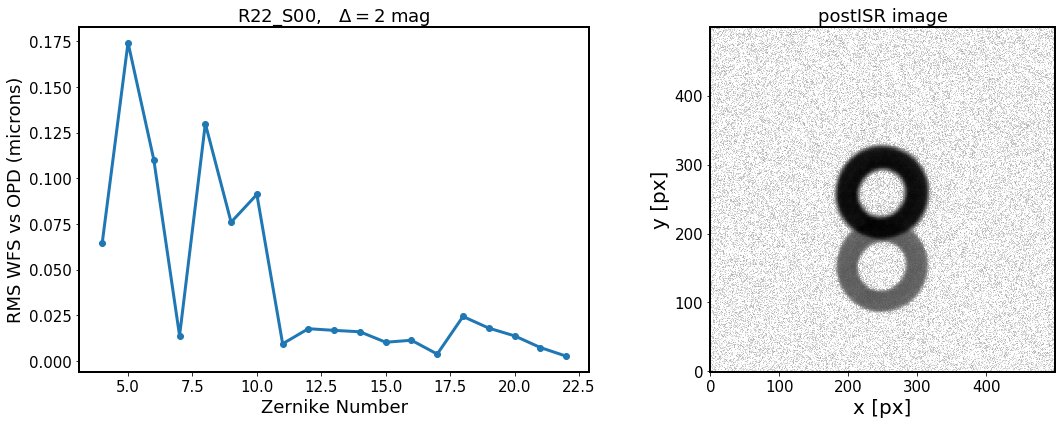

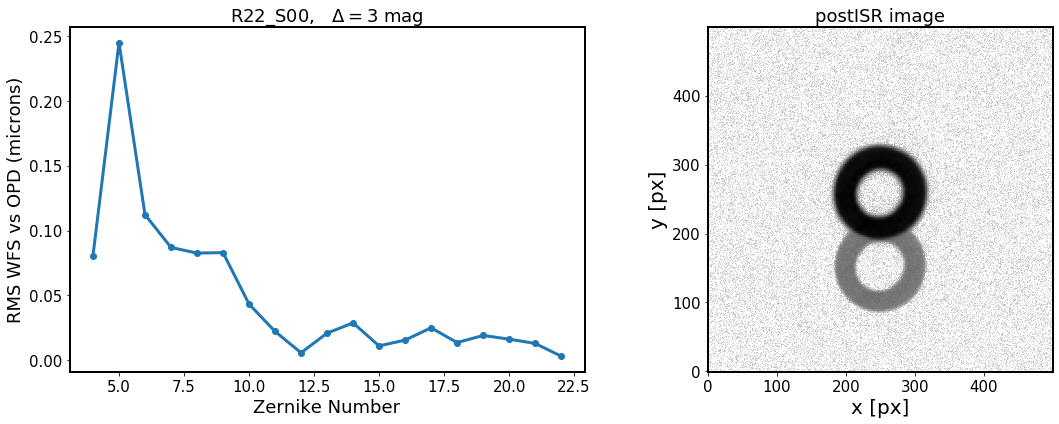

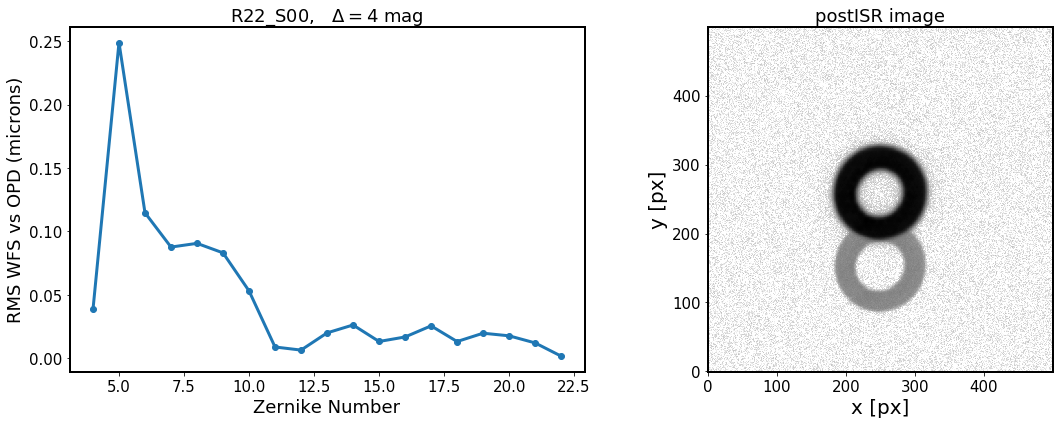

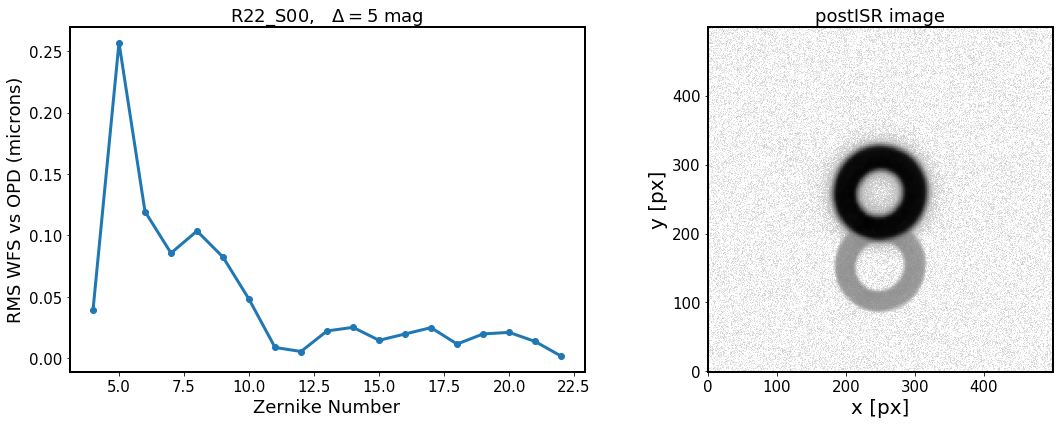

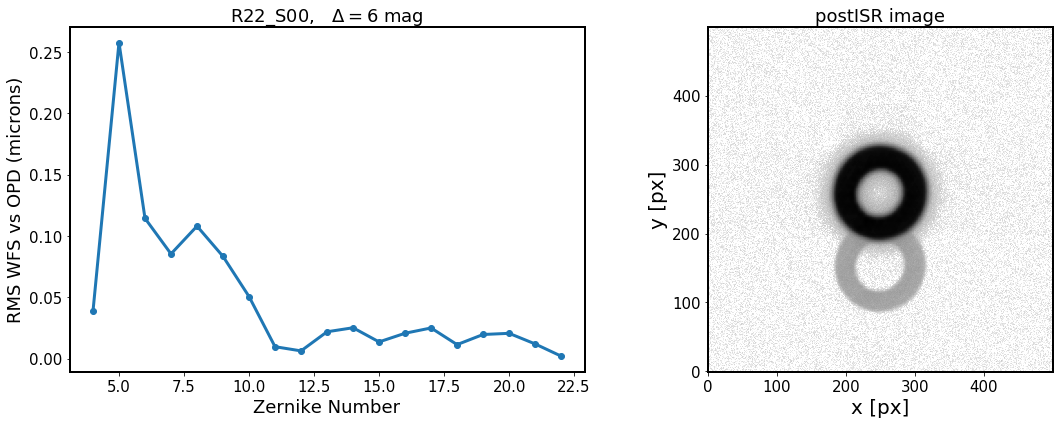

In [59]:
#  plot the Zernikes 
for i in range(len(magArr)):
    mag = magArr[i]
    rmsErrors = np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i])
    image = images[mag]
    
    at.plotZernikesAndCCD(image, rmsErrors, testLabel='mag', xlims=[1525,2025], ylims=[750,1250],
                      sensor = 'R22_S00', focalType='extra',savefig=True, magPrimary=16, mag=mag)
    
    

Also, plot the postage stamp images saved during the AOS loop in `WepController.py` `getDonutMap()`:

Using postage images from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpMagNew/mag_16/postage
Searching in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpMagNew/mag_16/postage directory

Available postage stamp images for sensor R22_S00: 

Looking for files that start with "extra_singleSciImg" and contain "R22_S00"...

Found 2 singleSciImg postage stamp images 
['extra_singleSciImg_sensor-R22_S00_star-0_id-0_posX-772_posY-1589.txt', 'extra_singleSciImg_sensor-R22_S00_star-1_id-1_posX-772_posY-1589.txt']

Looking for files that start with "extra_imgDeblend_full" and contain "R22_S00"...

Found 2 imgDeblend_full postage stamp images 
['extra_imgDeblend_full_sensor-R22_S00_star-0_id-0_posX-772_posY-1589.txt', 'extra_imgDeblend_full_sensor-R22_S00_star-1_id-1_posX-772_posY-1589.txt']

Looking for files that start with "extra_imgDeblend_resized" and contai

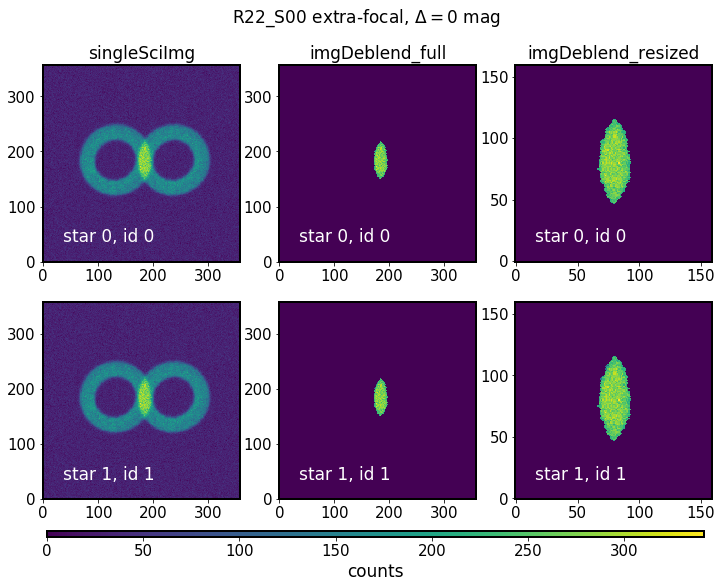

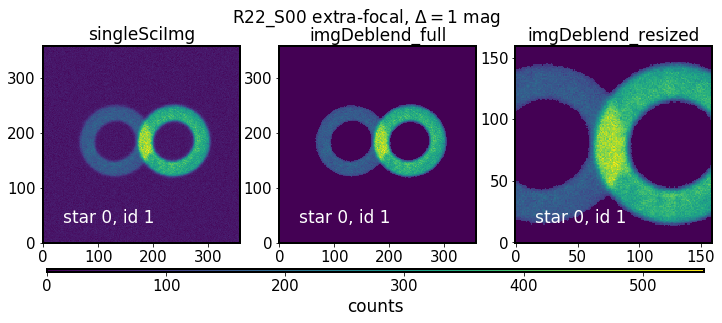

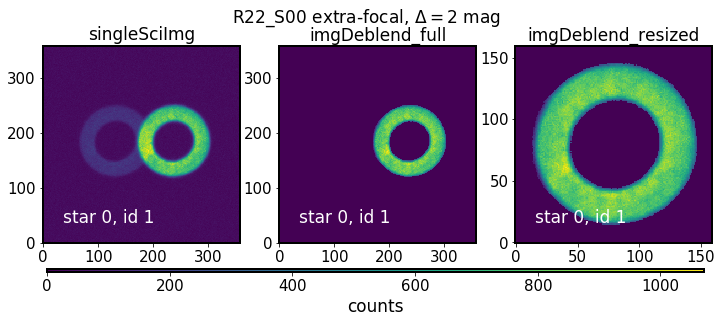

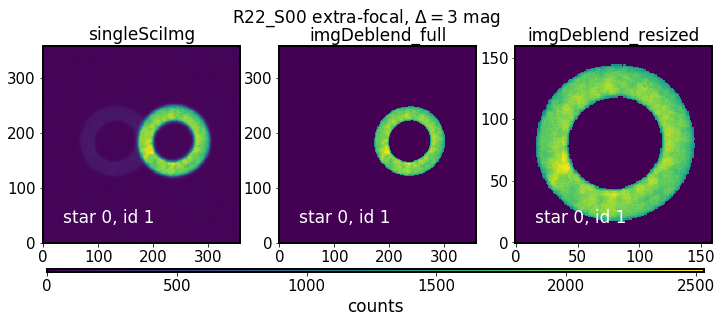

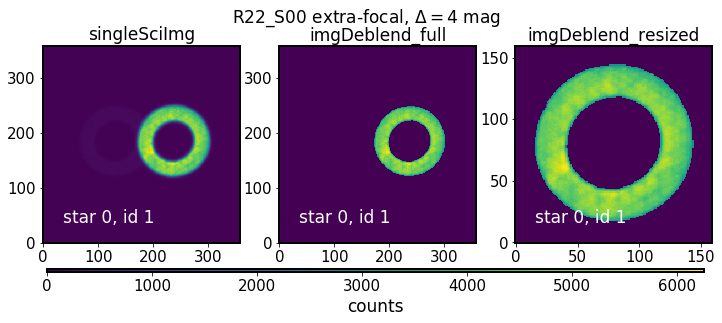

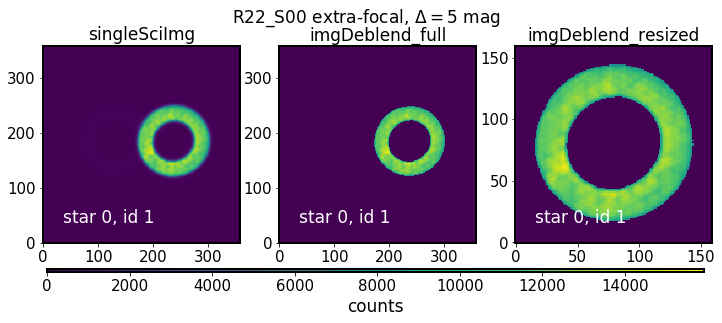

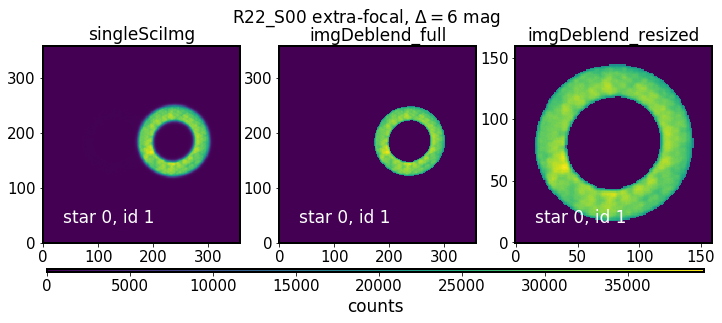

In [64]:
import imp
imp.reload(at)
# This only works for mag=16.  

# For some reason,  postage stamps do not get made for both stars with mag=15,14, etc.

# Perhaps the ts_wep code thinks it's just one star...

# Need to investigate

sensor='R22_S00'; focalType='extra';
for mag in [16,15,14,13,12,11,10]:
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    at.plotPostageStamps(data_dir, sensor=sensor, focalType=focalType, Nstars=2,
                         testLabel='mag', magPrimary=16, mag = mag)

Note: this reflects the deblending pipeline as of June 16, 2020. For any later updates one would need to rerun the pipeline, eg: 

    python runSingleAmpStarMag.py -expDir anotherStack